# Conversion Rate Differences between Desktop and Mobile Users
### Google Analytics Session-Level Analysis (1-month level)
**Purpose:** This notebook contains the technical statistical analysis used to evaluate conversion rate differences by device type. Results are summarized separately for non-technical stakeholders.  
**Question:** Do desktop users convert at a higher rate than mobile users?  
**Metric:** Session-level conversion rate  
**Method:** Chi-square test, confidence interval  
**Data**: The analysis uses Google Analytics session-level data aggregated over a one-month period.
Each row represents a single user session.

In [38]:
import pandas as pd 
import numpy as np
from scipy.stats import chi2_contingency
import math
from scipy.stats import norm
import matplotlib.pyplot as plt

In [43]:
df = pd.read_csv('data/google_analytics_20160801_20160831.csv')
df = df[df.device != "tablet"].copy() # narrow analysis to desktop vs. mobile 

#### Statistical Test: Chi-Square Test of Independence

In [32]:
summary = (df.groupby("device")["converted"]
           .agg(conversions="sum", sessions="count")
           .reindex(["mobile", "desktop"]))  # force order

table = np.array([
    [summary.loc["mobile", "conversions"],
     summary.loc["mobile", "sessions"] - summary.loc["mobile", "conversions"]],
    [summary.loc["desktop", "conversions"],
     summary.loc["desktop", "sessions"] - summary.loc["desktop", "conversions"]]
])

chi2, pval, dof, expected = chi2_contingency(table)
chi2, pval

(np.float64(113.5894955601403), np.float64(1.602812618996749e-26))

In [35]:
summary


,conversions,sessions
device,,
desktop,1070,60780
mobile,54,12080
tablet,21,1899


#### Estimation: 95% Confidence Interval for Conversion Rate Difference

In [33]:
summary = df.groupby("device")["converted"].agg(
    conversions="sum",
    sessions="count"
)

x1 = summary.loc["desktop", "conversions"]
n1 = summary.loc["desktop", "sessions"]

x2 = summary.loc["mobile", "conversions"]
n2 = summary.loc["mobile", "sessions"]

p1 = x1 / n1  # desktop
p2 = x2 / n2  # mobile

diff = p1 - p2

se = math.sqrt(
    (p1 * (1 - p1) / n1) +
    (p2 * (1 - p2) / n2)
)

z = norm.ppf(0.975)

ci_low = diff - z * se
ci_high = diff + z * se

ci_low, ci_high

(np.float64(0.011550534711508296), np.float64(0.014718018250101156))

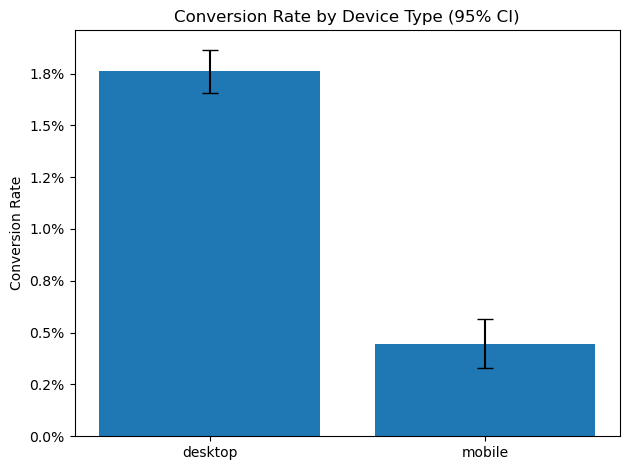

In [45]:
summary = df.groupby("device")["converted"].agg(
    conversions="sum",
    sessions="count"
)

summary["rate"] = summary["conversions"] / summary["sessions"]

z = norm.ppf(0.975)

summary["se"] = np.sqrt(
    (summary["rate"] * (1 - summary["rate"])) / summary["sessions"]
)

summary["ci_low"] = summary["rate"] - z * summary["se"]
summary["ci_high"] = summary["rate"] + z * summary["se"]

fig, ax = plt.subplots()

ax.bar(
    summary.index,
    summary["rate"],
    yerr=[
        summary["rate"] - summary["ci_low"],
        summary["ci_high"] - summary["rate"]
    ],
    capsize=6
)

ax.set_ylabel("Conversion Rate")
ax.set_title("Conversion Rate by Device Type (95% CI)")
ax.yaxis.set_major_formatter(lambda x, _: f"{x:.1%}")

plt.tight_layout()
plt.savefig("plots/conversion_rate_by_device_ci.png", dpi=300, bbox_inches="tight")
plt.show()